In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

np.random.seed(55)

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [3]:
schema_ratings = StructType([
    StructField("user_id", IntegerType(), False),
    StructField("item_id", IntegerType(), False),
    StructField("rating", IntegerType(), False),
    StructField("timestamp", IntegerType(), False)])

schema_items = StructType([
    StructField("item_id", IntegerType(), False),
    StructField("movie", StringType(), False)])

training = spark.read.option("sep", "\t").csv("../data/MovieLens.training", header=False, schema=schema_ratings)
test = spark.read.option("sep", "\t").csv("../data/MovieLens.test", header=False, schema=schema_ratings)
items = spark.read.option("sep", "|").csv("../data/MovieLens.item", header=False, schema=schema_items)

# Base Model

In [4]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9280351383611871

In [5]:
predictions.show()

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    251|    148|     2|886272547| 3.1684732|
|    332|    148|     5|887938486| 3.7142892|
|     44|    148|     4|878346946|  3.149143|
|    236|    148|     4|890117028| 2.3600805|
|    222|    148|     2|881061164| 2.9498837|
|    372|    148|     5|876869915| 3.7189827|
|    224|    148|     3|888104154| 3.2324755|
|      1|    148|     2|875240799| 2.6334004|
|    274|    148|     2|878946133| 3.4586027|
|    178|    148|     4|882824325| 3.5339444|
|    328|    148|     3|885048638|  3.127893|
|    164|    148|     5|889402203| 4.0321083|
|    120|    148|     3|889490499| 3.0315285|
|     92|    148|     2|877383934|  2.988411|
|    447|    148|     4|878854729| 2.9971828|
|     15|    148|     3|879456049| 2.9532206|
|     59|    148|     3|888203175| 3.1678908|
|     49|    148|     1|888068195| 1.3697612|
|    130|    148|     4|876251127|

In [6]:
userRecs = model.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

target_item = 243
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

Total users with 243: 0


# Training data analysis

In [7]:
movie = training.toPandas()
movie

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [8]:
len(movie.user_id.unique())

943

In [9]:
f = movie.groupby('item_id', as_index=False).count().sort_values(by=['rating'])
f = f[f['item_id'] == 243]
f

,item_id,user_id,rating,timestamp
242,243,108,108,108


In [10]:
movie.groupby('item_id').mean().sort_values(by=['rating']).iloc[300:305]

,user_id,rating,timestamp
item_id,,,
585,525.777778,2.472222,8.842056e+08
158,462.780000,2.480000,8.811020e+08
243,528.870370,2.490741,8.841078e+08
759,537.000000,2.500000,8.813114e+08
681,555.083333,2.500000,8.842872e+08


In [11]:
movie.rating.describe()

count    80000.000000
mean         3.528350
std          1.118565
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [12]:
ratings = movie.rating.to_numpy()
ratings

array([5, 3, 4, ..., 3, 3, 3], dtype=int32)

### Original Distribution

(array([ 4719.,     0.,  9178.,     0.,     0., 21963.,     0., 27396.,
            0., 16744.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

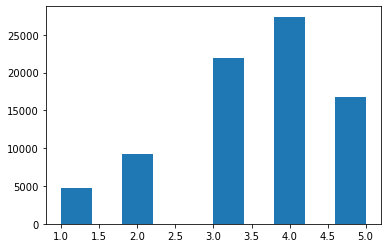

In [13]:
plt.hist(movie.rating)

(array([ 5778.,  4287.,  5607.,  7057., 10490., 10454.,  9415.,  8113.,
         8795., 10004.]),
 array([  1. ,  95.2, 189.4, 283.6, 377.8, 472. , 566.2, 660.4, 754.6,
        848.8, 943. ]),
 <BarContainer object of 10 artists>)

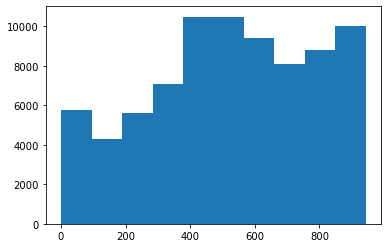

In [14]:
plt.hist(movie.user_id)

(array([18855., 22860., 11353.,  9279.,  7262.,  4428.,  3428.,  1500.,
          684.,   351.]),
 array([1.0000e+00, 1.6910e+02, 3.3720e+02, 5.0530e+02, 6.7340e+02,
        8.4150e+02, 1.0096e+03, 1.1777e+03, 1.3458e+03, 1.5139e+03,
        1.6820e+03]),
 <BarContainer object of 10 artists>)

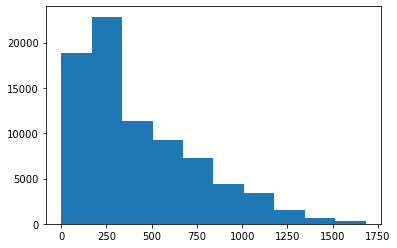

In [15]:
plt.hist(movie.item_id)

(array([568., 191.,  94.,  55.,  19.,  11.,   1.,   2.,   1.,   1.]),
 array([  4. ,  72.1, 140.2, 208.3, 276.4, 344.5, 412.6, 480.7, 548.8,
        616.9, 685. ]),
 <BarContainer object of 10 artists>)

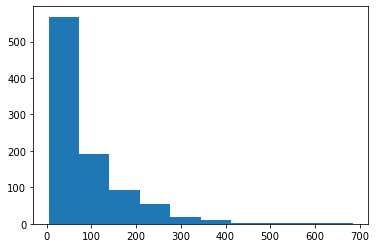

In [16]:
# Distribution of number of ratings by users
num_of_ratings = movie.groupby('user_id', as_index=False).agg({'rating':'count'}).rename(columns={'rating':'count'}).sort_values(by=['user_id'])
#num_of_ratings['count']
plt.hist(num_of_ratings['count'])

# Generate the random ratings from the global distribution

# New Random attack with 50 user profiles

In [17]:
# Generate 50 user_ids
number_of_ids = 50
starting_id = 1000
new_user_ids = np.arange(starting_id, starting_id+number_of_ids)

In [18]:
# Get list of number of ratings for the 50 users
def get_num_of_ratings(num_of_ratings, add_noise = True):
    num_of_ratings_list = num_of_ratings['count'].sample(n=number_of_ids, random_state=1, replace=True).to_numpy()
    if add_noise:
        x = np.arange(-10, 11)
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
        prob = prob / prob.sum() # normalize the probabilities so their sum is 1
        nums = np.random.choice(x, size = 50, p = prob)
        num_of_ratings_list = num_of_ratings_list + nums
    return num_of_ratings_list


In [19]:
def generate_attack(new_user_ids, num_of_ratings_list, target_item = -1):
    if len(new_user_ids) != len(num_of_ratings_list):
        raise Exception()
    
    
    attack_df = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])
    for i in range(len(new_user_ids)):
        user_id = new_user_ids[i]
        num_of_ratings = num_of_ratings_list[i]
        
        random_movies = movie['item_id'].sample(n=num_of_ratings, random_state=3).to_numpy()
        random_ratings = movie['rating'].sample(n=num_of_ratings, random_state=55, replace=True).to_numpy()
        
        for j in range(num_of_ratings):
            if(target_item != random_movies[j]):
                attack_df.loc[len(attack_df.index)] = [user_id, random_movies[j], random_ratings[j]] 
        
        if target_item >= 0:
            attack_df.loc[len(attack_df.index)] = [user_id, target_item, 5]
    
    return attack_df



In [20]:
num_of_ratings_list = get_num_of_ratings(num_of_ratings, add_noise=False)
attack_df = generate_attack(new_user_ids, num_of_ratings_list)
attack_df

,user_id,item_id,rating
0,1000,190,5
1,1000,802,4
2,1000,524,5
3,1000,951,3
4,1000,73,3
...,...,...,...
4213,1049,27,3
4214,1049,778,5
4215,1049,931,5
4216,1049,194,5


In [21]:
attack = pd.concat([movie, attack_df]).sort_values(by=['user_id', 'item_id'])
attack

,user_id,item_id,rating,timestamp
0,1,1,5,874965758.0
1,1,2,3,876893171.0
2,1,3,4,878542960.0
3,1,4,3,876893119.0
4,1,5,3,889751712.0
...,...,...,...,...
4199,1049,1162,2,NaN
4169,1049,1210,4,NaN
4094,1049,1313,3,NaN
4089,1049,1401,1,NaN


In [22]:
attackedDF = spark.createDataFrame(attack)
attackedDF

DataFrame[user_id: bigint, item_id: bigint, rating: bigint, timestamp: double]

### Random Attack with no target item

In [23]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9306249901555625

In [24]:
predictions.show()

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    251|    148|     2|886272547| 3.1386251|
|    332|    148|     5|887938486| 3.7242196|
|     44|    148|     4|878346946| 3.1477008|
|    236|    148|     4|890117028| 2.3804333|
|    222|    148|     2|881061164| 2.9588704|
|    372|    148|     5|876869915|  3.741238|
|    224|    148|     3|888104154| 3.2290816|
|      1|    148|     2|875240799| 2.6296692|
|    274|    148|     2|878946133| 3.4737546|
|    178|    148|     4|882824325| 3.5442045|
|    328|    148|     3|885048638| 3.1154053|
|    164|    148|     5|889402203| 3.9368055|
|    120|    148|     3|889490499|  3.038677|
|     92|    148|     2|877383934|  2.984211|
|    447|    148|     4|878854729| 2.9939713|
|     15|    148|     3|879456049| 2.9659128|
|     59|    148|     3|888203175|  3.151857|
|     49|    148|     1|888068195|  1.368145|
|    130|    148|     4|876251127|

In [25]:
userRecs = model.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

target_item = 243
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

Total users with 243: 0


In [26]:
def get_n_recommendations(predictions, n=10):
    p = predictions.sort_values(by=['user_id', 'prediction'], ascending=[True, False])
    p2 = p.groupby('user_id')['item_id'].apply(list).reset_index(name='movies')
    p2['movies'] = p2['movies'].apply(lambda l: l[:n])
    return p2

def get_occurences(top_rec, target_item):
    t = top_rec['movies'].to_numpy()
    count = 0
    for i in t:
        for j in i:
            if j == target_item:
                count += 1
    return count

In [27]:
top_10 = get_n_recommendations(predictions.toPandas(), n=10)
top_10

,user_id,movies
0,1,"[134, 98, 100, 171, 174, 64, 12, 189, 190, 185]"
1,2,"[251, 19, 313, 50, 315, 316, 297, 303, 292, 298]"
2,3,"[272, 318, 345, 327, 307, 337, 324, 328, 354, ..."
3,4,"[357, 50, 303, 361, 354, 294, 288, 260, 264, 356]"
4,5,"[89, 173, 176, 100, 1, 109, 445, 222, 144, 382]"
...,...,...
454,457,"[443, 192, 182, 636, 708, 366, 704, 775]"
455,458,"[1101, 648, 144]"
456,459,[934]
457,460,[10]


In [28]:
get_occurences(top_10, 243)

5

### Attack with target item 243

In [29]:
attack_df = generate_attack(new_user_ids, num_of_ratings_list, target_item=243)
attack = pd.concat([movie, attack_df]).sort_values(by=['user_id', 'item_id'])
attackedDF = spark.createDataFrame(attack)

In [30]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.93057390847291

In [31]:
predictions.show()

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    251|    148|     2|886272547| 3.1497931|
|    332|    148|     5|887938486| 3.7168124|
|     44|    148|     4|878346946| 3.1586883|
|    236|    148|     4|890117028|  2.366842|
|    222|    148|     2|881061164| 2.9625554|
|    372|    148|     5|876869915| 3.7326238|
|    224|    148|     3|888104154|  3.224727|
|      1|    148|     2|875240799|  2.633157|
|    274|    148|     2|878946133| 3.4688692|
|    178|    148|     4|882824325| 3.5508163|
|    328|    148|     3|885048638| 3.1187973|
|    164|    148|     5|889402203|  3.956076|
|    120|    148|     3|889490499| 3.0193605|
|     92|    148|     2|877383934|  3.003532|
|    447|    148|     4|878854729| 3.0083034|
|     15|    148|     3|879456049| 2.9770346|
|     59|    148|     3|888203175| 3.1549435|
|     49|    148|     1|888068195| 1.3571875|
|    130|    148|     4|876251127|

In [32]:
top_10 = get_n_recommendations(predictions.toPandas(), n=10)
top_10

,user_id,movies
0,1,"[134, 100, 98, 171, 174, 64, 12, 189, 185, 183]"
1,2,"[251, 19, 50, 313, 315, 316, 297, 303, 292, 298]"
2,3,"[272, 318, 345, 327, 307, 337, 324, 328, 354, ..."
3,4,"[357, 50, 303, 361, 354, 294, 288, 260, 264, 356]"
4,5,"[89, 173, 176, 100, 1, 109, 445, 222, 144, 382]"
...,...,...
454,457,"[443, 192, 182, 636, 708, 366, 704, 775]"
455,458,"[1101, 648, 144]"
456,459,[934]
457,460,[10]


In [33]:
get_occurences(top_10, 243)

4

In [35]:
userRecs = model.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

target_item = 243
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

1025 [524, 128, 190, 945, 162, 272, 443, 243, 321, 151]
1005 [190, 524, 272, 128, 162, 443, 151, 243, 321, 945]
1016 [524, 190, 443, 162, 151, 272, 243, 128, 945, 321]
1031 [190, 524, 162, 272, 443, 151, 243, 128, 945, 321]
1030 [128, 524, 190, 162, 243, 443, 945, 272, 321, 151]
1034 [524, 190, 128, 162, 443, 243, 272, 321, 151, 945]
1019 [190, 524, 162, 443, 272, 151, 321, 243, 128, 945]
1046 [524, 128, 190, 162, 443, 243, 272, 945, 321, 151]
1047 [524, 190, 443, 162, 272, 151, 128, 243, 945, 321]
1021 [524, 190, 272, 128, 162, 443, 151, 243, 321, 945]
1026 [524, 190, 443, 151, 162, 272, 243, 128, 945, 321]
1028 [190, 524, 443, 162, 151, 272, 243, 128, 945, 321]
1029 [190, 524, 443, 162, 151, 272, 128, 243, 945, 321]
1002 [524, 190, 443, 162, 272, 151, 128, 243, 945, 321]
1048 [524, 190, 443, 151, 162, 272, 243, 128, 945, 321]
1035 [524, 128, 190, 162, 945, 272, 443, 243, 321, 615]
1045 [524, 190, 443, 151, 243, 272, 162, 128, 945, 321]
1017 [190, 524, 443, 162, 151, 272, 128, 243, 94

### 1000 Generated

In [ ]:
injections = 10000
# 50 user profiles
# Generate according to the distribution

In [ ]:
random_ratings = movie['rating'].sample(n=injections, random_state=1, replace=True).to_numpy()
#random_ratings

In [ ]:
plt.hist(random_ratings)

In [ ]:
random_users = movie['user_id'].sample(n=injections, random_state=2, replace=True).to_numpy()
#random_users

In [ ]:
plt.hist(random_users)

In [ ]:
random_movies = movie['item_id'].sample(n=injections, random_state=3).to_numpy()
#random_movies

In [ ]:
plt.hist(random_movies)

In [ ]:
attack_1000 = pd.DataFrame({'user_id': random_users, 'item_id': random_movies, 'rating': random_ratings})
attack_1000

In [ ]:
attack = pd.concat([movie, attack_1000]).sort_values(by=['user_id', 'item_id'])
attack

In [ ]:
attackedDF = spark.createDataFrame(attack)
attackedDF

# Evaluate based on the random attack

In [ ]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

RMSE is basically the same..

In [ ]:
predictions.show()